In [1]:
#                            Package Import Section                            #
# ---------------------------------------------------------------------------- #
# region IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import os
import traceback
import pandas as pd
from scipy.stats import iqr, norm


# from surfalize import Surface

# Import the modules
import opd_read
import edge_detect
import laser_orientation
import flattening
import crown_extraction
import filters
import shared_plotting_functions
import statistics_functions

# Import the importlib module
import importlib

# Reload the modules
importlib.reload(opd_read)
importlib.reload(edge_detect)
importlib.reload(laser_orientation)
importlib.reload(flattening)
importlib.reload(crown_extraction)
importlib.reload(filters)
importlib.reload(shared_plotting_functions)
importlib.reload(statistics_functions)

# Re-import the functions
from opd_read import read_wyko_opd
from edge_detect import edge_detection
from laser_orientation import estimate_rotation_and_cs
from flattening import flatten
from crown_extraction import extract_crown_profiles
from filters import crown_delta_filter, crown_average_filter
from shared_plotting_functions import (
    remove_offset,
    generate_unique_colors,
    generate_laser_plotting_order,
)
from statistics_functions import (
    calculate_r_squared,
    IQR_filtering,
    common_data_filter,
    calculate_statistics_single_column,
    stats_to_dataframe,
    save_statistics_to_excel,
)

# Define Maps for edge and centre cubes
EDGE_CUBES = [
    "166",
    "167",
    "147",
    "148",
    "185",
    "128",
    "177",
    "157",
    "158",
    "138",
    "139",
    "120",
    "205",
    "195",
    "90",
    "81",
]
CENTRE_CUBES = ["161", "162", "163", "142", "143", "144", "123", "124", "136"]

# endregion
# Close all plots, clear data in workspace and records in Command Window.
plt.close("all")
# Clear all variables (not directly applicable in Python, but resetting relevant variables)
DATASETS = []

# User Input

In [2]:
#                      USER INPUT / CONFIGURATION SECTION                      #
# ---------------------------------------------------------------------------- #
# region USER INPUTS

# ---------------- Input and Output Paths + Analysis Plot Names -------------- #
INPUTPATH = "C:\\Users\\762093\\Documents\\WYKO_DATA"
OUTPUTPATH = "C:\\Users\\762093\\Documents\\WYKO_DATA\\output_debug"

CAMPAIGN_NAME = "pythonprototyping"


# ---------------------------- DATASETS to Analyse --------------------------- #
DATASETS = [
    "QCHUP_CUBE_161",
    "QCHUP_CUBE_167",
    # "240039_CUBE_LEFT3",
    # "240039_CUBE_LEFT4",
    # Add more DATASETS as needed
]
NUMDATA = len(DATASETS)

# ------- Option to group and color label plots based on 'design infos' ------ #
GROUP_BY_DESIGN_INFO = (
    False  # Set to true to group by design infos, false to group by waferID and cubeID
)

DESIGN_INFOS = [
    "60s RTA - G Dense",
    "60s RTA - G Dense",
]  # Few Files Check

# ------------------------------------------ Stamp Info ------------------------------------------ #
STAMP_IDS = [
    240058,
    240025,
]

# ------- input the number of ROWS and columns in measured laser array. ------- #
ROWS = 3
COLS = 7
ROWRANGE = range(1, ROWS + 1)
COLRANGE = range(1, COLS + 1)


# -------------------------- Colours of Each Dataset ------------------------- #
# COLOURS = [[1, 0.5, 0], [0.5, 0, 0.5], [1, 0.5, 0], [0, 0, 1], [1, 0, 1]]


# Saved Images Quality (300 for decent runtime)
IMGQUAL = 300


# ----------------------------------------- Plotting Lims ---------------------------------------- #
ZLIM = 200  # zlims on the colour map plots
SUMMARYLIMS = [-300, 300]  # Yaxis lims on the summary plots


# ------------------------------ Filter Settings ----------------------------- #
# The "DELTA_THRESHOLD" will give the maximum allowed difference between adjacent
# heights (in nm). If above this value, the code will filter out this data point
# as unphysical
#
# The "ANOMALY_THRESHOLD" gives a similar maximum for a separate filter. This filter
# runs an average of 60 points surrounding each point, and if the target is
# different above this set threshold, then it is filtered out as unphysical.
# This should be set higher than the "DELTA_THRESHOLD".
APPLY_DELTA_FILTER = True
APPLY_AVERAGE_FILTER = True

DELTA_THRESHOLD = 4  # Adjust this value as needed
ANOMALY_THRESHOLD = 20  # Adjust this value as needed
WINDOW_SIZE_INPUT = 20  # Adjust this value as needed


# --------------- Image Detection Parameters for Edge Detection -------------- #
EDGEDETECT = 3  # parameter for edge detect function. only change when needed.
LEFTEDGEWINDOW = [
    [200, 450],
    [150, 300],
]  # window for left edge detect, specify Y and X ranges respectively.


# --------------------------- Different Array Sizes -------------------------- #
#  Set this to true if you want different array sizes within an analysis
#  batch. The sizes can be set in the row_dynamic and column_dynamic vectors
# . row_dynamic and column_dynamic ARE NOT USED IF THIS IS SET TO FALSE, ALL
# THE ARRAY SIZES ARE PRESUMED TO FOLLOW THE INITIAL "ROWS" and "columns"
# setting
DYNAMIC_ARRAYS = False

ROW_DYNAMIC = [4, 2]

COLUMN_DYNAMIC = [20, 20]


# ------------------------- Plotting Indexing Option: ROW  ------------------------- #
PLOT_BY_COLUMN = True

# endregion USER INPUTS

# Processing and Image Analysis

In [3]:
#                             Preprocessing Steps                              #
# ---------------------------------------------------------------------------- #

# Create output directory if it doesn't exist
os.makedirs(OUTPUTPATH, exist_ok=True)

# Check if the lengths of datasets and design_infos match
if len(DATASETS) != len(DESIGN_INFOS):
    if len(DESIGN_INFOS) < len(DATASETS):
        DESIGN_INFOS.extend(["unspecified"] * (len(DATASETS) - len(DESIGN_INFOS)))
    elif len(DESIGN_INFOS) > len(DATASETS):
        DESIGN_INFOS = DESIGN_INFOS[: len(DATASETS)]
# Verify lengths match after adjustment
if len(DATASETS) != len(DESIGN_INFOS):
    raise ValueError(
        "Number of datasets not equal to number of design infos! Please make sure lengths match."
    )


# ---------------------- Initialize location_labels list --------------------- #
location_labels = []
# Determine edge or centre for each cubeID
for dataset in DATASETS:
    _, cubeID = dataset.split("_CUBE_")
    if cubeID in EDGE_CUBES:
        location_labels.append("Edge")
    elif cubeID in CENTRE_CUBES:
        location_labels.append("Centre")
    else:
        location_labels.append("Other")  # In case the cubeID is not found in either list


# ----------------------- Initialize laserIDranges list ---------------------- #
laserIDranges = []
# Loop through each dataset to calculate and store laserIDrange
for dataset in DATASETS:
    if DYNAMIC_ARRAYS:
        index = DATASETS.index(dataset)
        rows = ROW_DYNAMIC[index]
        cols = COLUMN_DYNAMIC[index]
        rowrange = range(1, rows + 1)
        colrange = range(1, cols + 1)
        laserIDranges.append(list(range(1, len(rowrange) * len(colrange) + 1)))
    else:
        # If DYNAMIC_ARRAYS is false, use a default range (adjust as needed)
        rowrange = range(1, ROWS + 1)
        colrange = range(1, COLS + 1)
        laserIDranges.append(list(range(1, len(rowrange) * len(colrange) + 1)))


# Separate the datasets list into waferIDs and cubeIDs
waferIDs = [dataset.split("_CUBE_")[0] for dataset in DATASETS]
cubeIDs = [dataset.split("_CUBE_")[1] for dataset in DATASETS]


# Generate the laser plotting order
laser_plotting_order = generate_laser_plotting_order(
    laserIDranges, ROW_DYNAMIC, COLUMN_DYNAMIC, ROWS, COLS, PLOT_BY_COLUMN, DYNAMIC_ARRAYS
)

# Print the laser plotting order for verification
print("Laser Plotting Order: ", laser_plotting_order)

Laser Plotting Order:  [[0, 3, 6, 9, 12, 15, 18, 1, 4, 7, 10, 13, 16, 19, 2, 5, 8, 11, 14, 17, 20], [0, 3, 6, 9, 12, 15, 18, 1, 4, 7, 10, 13, 16, 19, 2, 5, 8, 11, 14, 17, 20]]


In [4]:
#                          Initialisation of Data Storage Variables                                #
# ------------------------------------------------------------------------------------------------ #

data_raw = [None] * NUMDATA
data_processed = [None] * NUMDATA
data_crownprofiles = [None] * NUMDATA
data_xcrownprofiles = [None] * NUMDATA
data_crowns = [None] * NUMDATA
angle_matrix = [None] * NUMDATA
# Loop through each dataset to preallocate inner lists (FOR INCREASED PROCESSING SPEED)
for dataind in range(NUMDATA):
    laserIDrange = laserIDranges[dataind]
    # Preallocate inner lists
    data_raw[dataind] = [None] * len(laserIDrange)
    data_processed[dataind] = [None] * len(laserIDrange)
    data_crownprofiles[dataind] = [None] * len(laserIDrange)
    data_xcrownprofiles[dataind] = [None] * len(laserIDrange)
    data_crowns[dataind] = np.full((len(laserIDrange), 3), np.nan)  # Initialize with NaNs,
    # 3 columns for Ycrown, XcrownP and XcrownN respectively
    angle_matrix[dataind] = np.full((len(laserIDrange), 4), np.nan)  # Initialize with NaNs

processedMessages = []

In [5]:
#                       MAIN PROCESSING: Iterate Processing Loop over all input Data                       #
# ---------------------------------------------------------------------------- #
# region Iterative Loop
# Loop to read and process all opd files

# ITERATE FOR EACH DATASET
for dataind, dataset in enumerate(DATASETS):
    waferID, cubeID = dataset.split("_CUBE_")
    print(f"\n{waferID} CUBE {cubeID} is in processing.")

    # Define the input path for the current cube
    cubePath = os.path.join(INPUTPATH, dataset)

    # Detect the format of the .opd file
    test_files = [f for f in os.listdir(cubePath) if f.endswith(".fc.opd")]
    if not test_files:
        raise FileNotFoundError(f"No .opd files found in the directory: {cubePath}")

    # Read the first .opd file to determine the format
    test_file_name = test_files[0]
    if "Row_" in test_file_name and "_Col_" in test_file_name:
        opdfilenameformat = "Row_{0}_Col_{1}_"
    elif "row" in test_file_name and "column" in test_file_name:
        opdfilenameformat = "row{0}column{1}"
    else:
        raise ValueError(f"Unknown .opd file format: {test_file_name}")

    # Determine rowrange and colrange based on DYNAMIC_ARRAYS
    if DYNAMIC_ARRAYS:
        rows = ROW_DYNAMIC[dataind]
        cols = COLUMN_DYNAMIC[dataind]
        rowrange = range(1, rows + 1)
        colrange = range(1, cols + 1)
    else:
        rows = ROWS
        cols = COLS
        rowrange = ROWRANGE
        colrange = COLRANGE

    # endregion Iterative Loop

    # ITERNATE FOR ALL LASERS PER DATASET
    # Iterate over all lasers per dataset using nested loops for rows and columns
    for rowID in rowrange:
        for colID in colrange:
            laserIDind = (rowID - 1) * cols + (colID - 1)
            print(f"Processing Laser {laserIDind + 1}: Row {rowID}, Column {colID}")

            # ---------------------------------------------------------------------------- #
            #                              Reading .opd Files                              #
            # ---------------------------------------------------------------------------- #
            opdfilename = opdfilenameformat.format(rowID, colID)
            filename = os.path.join(cubePath, f"{opdfilename}.fc.opd")

            try:
                # Reading .opd Files
                blocks, params, image_raw = read_wyko_opd(filename)
                last_valid_image_raw = image_raw

            except FileNotFoundError:
                if last_valid_image_raw is not None:
                    print(f"File missing: {filename}. Using the last valid image.")
                    image_raw = last_valid_image_raw
                else:
                    print(f"File missing: {filename}. No valid image found to copy from.")
                    continue

            Resolution = float(params["Pixel_size"]) * 1000

            # ---------------------------------------------------------------------------- #
            #                               Image Processing                               #
            # ---------------------------------------------------------------------------- #
            laser_edge, image_raw_positive = edge_detection(image_raw, EDGEDETECT)

            try:
                leftedge_angle, center_CS = estimate_rotation_and_cs(
                    laser_edge, Resolution, LEFTEDGEWINDOW, image_raw
                )
            except Exception as e:
                print("An error occurred:", e)
                traceback.print_exc()
                continue

            # Plane Fitting
            data_processed_laser, theta_z_real, roll_angle, pitch_angle = flatten(
                image_raw_positive, Resolution, center_CS, leftedge_angle
            )
            yaw_angle = -leftedge_angle

            # Store raw and processed data
            image_raw_no_offset = remove_offset(image_raw)
            data_raw[dataind][laserIDind] = image_raw_no_offset
            data_processed[dataind][laserIDind] = data_processed_laser
            angle_matrix[dataind][laserIDind] = [theta_z_real, roll_angle, pitch_angle, yaw_angle]

            # ---------------------------------------------------------------------------- #
            #                           Crown Profile Extraction                           #
            # ---------------------------------------------------------------------------- #
            crown_profile, xcrown_profile = extract_crown_profiles(data_processed_laser, Resolution)

            # Apply filters to the crown and xcrown profiles
            if APPLY_DELTA_FILTER:
                crown_profile = crown_delta_filter(crown_profile, DELTA_THRESHOLD)
                xcrown_profile = crown_delta_filter(xcrown_profile, DELTA_THRESHOLD)
            if APPLY_AVERAGE_FILTER:
                crown_profile = crown_average_filter(
                    crown_profile, window_size=WINDOW_SIZE_INPUT, threshold=ANOMALY_THRESHOLD
                )
                xcrown_profile = crown_average_filter(
                    xcrown_profile, window_size=WINDOW_SIZE_INPUT, threshold=ANOMALY_THRESHOLD
                )

            # Calculate crown_values and xcrown values
            edgedistance = 0  # pixel numbers
            crown_value = 0 - 0.5 * (
                crown_profile[edgedistance, 1] + crown_profile[-edgedistance - 1, 1]
            )
            xcrownP_value = 0 - xcrown_profile[edgedistance, 1]
            xcrownN_value = 0 - xcrown_profile[-edgedistance - 1, 1]

            # Adjust profiles by adding the single crown value to every value in the profile
            crown_profile[:, 1] += crown_value
            xcrown_profile[:, 1] += (xcrownP_value + xcrownN_value) / 2

            # Store crown profiles and values
            data_crownprofiles[dataind][laserIDind] = crown_profile
            data_xcrownprofiles[dataind][laserIDind] = xcrown_profile
            data_crowns[dataind][laserIDind] = [crown_value, xcrownP_value, xcrownN_value]
            # print(f"Assigned to data_crowns[{dataind}][{laserIDind}]: YCrown = {crown_value}, XCrownP = {xcrownP_value}, XCrownN = {xcrownN_value}")


QCHUP CUBE 161 is in processing.
Processing Laser 1: Row 1, Column 1
Processing Laser 2: Row 1, Column 2
Processing Laser 3: Row 1, Column 3
Processing Laser 4: Row 1, Column 4
Processing Laser 5: Row 1, Column 5
Processing Laser 6: Row 1, Column 6
Processing Laser 7: Row 1, Column 7
Processing Laser 8: Row 2, Column 1
Processing Laser 9: Row 2, Column 2
Processing Laser 10: Row 2, Column 3
Processing Laser 11: Row 2, Column 4
Processing Laser 12: Row 2, Column 5
Processing Laser 13: Row 2, Column 6
Processing Laser 14: Row 2, Column 7
Processing Laser 15: Row 3, Column 1
Processing Laser 16: Row 3, Column 2
Processing Laser 17: Row 3, Column 3
Processing Laser 18: Row 3, Column 4
Processing Laser 19: Row 3, Column 5
Processing Laser 20: Row 3, Column 6
Processing Laser 21: Row 3, Column 7

QCHUP CUBE 167 is in processing.
Processing Laser 1: Row 1, Column 1
Processing Laser 2: Row 1, Column 2
Processing Laser 3: Row 1, Column 3
Processing Laser 4: Row 1, Column 4
Processing Laser 5: 

# Results Exports

In [ ]:
# -------------------------------- Initial Value Printer / Summary ------------------------------- #
print("-------------------------- Data Processing is Completed! --------------------------")
print("Summary of all processed Datsets:")
for dataset in DATASETS:
    print(f"{dataset} has been processed.")

# -------------------------- Print crown values -------------------------- #
print("\nCrown values for each dataset:")
# print(data_crowns)
for dataind, dataset in enumerate(DATASETS):
    waferID, cubeID = dataset.split("_CUBE_")
    print(f"\n{waferID} CUBE {cubeID}:")
    for laserIDind, crown_values in enumerate(data_crowns[dataind]):
        ycrown, xcrownP, xcrownN = crown_values
        print(
            f"  Laser {laserIDind + 1}: YCrown = {ycrown:.2f} nm, XCrownP = {xcrownP:.2f} nm, XCrownN = {xcrownN:.2f} nm"
        )

# ------------------------------- Print angles ------------------------------- #
print("\nAngles for each dataset:")
for dataind, dataset in enumerate(DATASETS):
    waferID, cubeID = dataset.split("_CUBE_")
    print(f"\n{waferID} CUBE {cubeID}:")
    for laserIDind, angles in enumerate(angle_matrix[dataind]):
        theta_z_real, roll_angle, pitch_angle, yaw_angle = angles
        print(
            f"  Laser {laserIDind + 1}: Roll = {roll_angle:.2f} degrees, Pitch = {pitch_angle:.2f} degrees, Yaw = {yaw_angle:.2f} degrees"
        )

# # -------------------------- Print crown profiles -------------------------- #
# print("\nCrown profiles for each dataset:")
# for dataind, dataset in enumerate(DATASETS):
#     waferID, cubeID = dataset.split('_CUBE_')
#     print(f"\n{waferID} CUBE {cubeID}:")
#     for laserIDind, crown_profile in enumerate(data_crownprofiles[dataind]):
#         print(f"  Laser {laserIDind + 1} Crown Profile:")
#         for point in crown_profile:
#             print(f"    {point}")

### Raw Topography Results

In [12]:
# ---------------------- Save Crown Numbers in Excel File ---------------------- #



def save_crowns_to_excel(output_path, waferID, cubeID, laserIDrange, data_crowns, angle_matrix):

    # Create a list to hold the data

    crown_data = []

    for laserID in laserIDrange:

        laserID_index = laserID - 1

        crown_row = [
            laserID,

            data_crowns[laserID_index][0],
            data_crowns[laserID_index][1],
            data_crowns[laserID_index][2],
            angle_matrix[laserID_index][0],
            angle_matrix[laserID_index][1],
            angle_matrix[laserID_index][2],
            angle_matrix[laserID_index][3],
        ]


        crown_data.append(crown_row)


    # Define column names


    columns = ["LaserID", "YCrown", "XCrown_P", "XCrown_N", "Theta_z", "Roll", "Pitch", "Yaw"]


    # Create a DataFrame

    df = pd.DataFrame(crown_data, columns=columns)


    # Define the output file name


    output_file = os.path.join(output_path, f"{waferID}_{cubeID}_Crown_Data.xlsx")


    # Save the DataFrame to an Excel file


    df.to_excel(output_file, index=False)

    print(f"Data saved to {output_file}")



# Save data to Excel files for each waferID-cubeID pair


for dataind, dataset in enumerate(DATASETS):

    waferID, cubeID = dataset.split("_CUBE_")

    laserIDrange = laserIDranges[dataind]

    save_crowns_to_excel(
        OUTPUTPATH, waferID, cubeID, laserIDrange, data_crowns[dataind], angle_matrix[dataind]
    )

Data saved to C:\Users\762093\Documents\WYKO_DATA\output_debug\QCHUP_161_Crown_data.xlsx
Data saved to C:\Users\762093\Documents\WYKO_DATA\output_debug\QCHUP_167_Crown_data.xlsx


In [10]:
# ------------------------------- Save Crown Profiles in Excel File ------------------------------ #


def export_all_datasets_to_excel(output_path, datasets, data_crownprofiles_list, name):
    """
    Export crown profile data to Excel files, one file per dataset.

    Parameters:
    - output_path: The directory where the Excel files will be saved.
    - datasets: A list of dataset names.
    - data_crownprofiles_list: A list of crown profiles for each dataset.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    # Loop through each dataset and its corresponding crown profiles
    for dataset_name, data_crownprofiles in zip(datasets, data_crownprofiles_list):
        # Create a DataFrame to hold all crown profiles for the dataset
        all_profiles = []

        # Loop through each laser's crown profile data
        for laser_id, crown_profile in enumerate(data_crownprofiles):
            # Create a DataFrame from the crown profile data
            df = pd.DataFrame(crown_profile, columns=["Position (um)", "Height (nm)"])
            df["LaserID"] = laser_id + 1  # Add a column for LaserID

            # Append to the list of all profiles
            all_profiles.append(df)

        # Concatenate all profiles into a single DataFrame
        all_profiles_df = pd.concat(all_profiles, ignore_index=True)

        # Define the output file name
        output_file = os.path.join(output_path, f"{dataset_name}_All_{name}_Profiles.xlsx")

        # Save the DataFrame to an Excel file
        all_profiles_df.to_excel(output_file, index=False)

        print(f"All crown profiles for {dataset_name} saved to {output_file}")


export_all_datasets_to_excel(OUTPUTPATH, DATASETS, data_crownprofiles, "YCrown")
export_all_datasets_to_excel(OUTPUTPATH, DATASETS, data_xcrownprofiles, "XCrown")

All crown profiles for QCHUP_CUBE_161 saved to C:\Users\762093\Documents\WYKO_DATA\output_debug\QCHUP_CUBE_161_All_YCrown_Profiles.xlsx
All crown profiles for QCHUP_CUBE_167 saved to C:\Users\762093\Documents\WYKO_DATA\output_debug\QCHUP_CUBE_167_All_YCrown_Profiles.xlsx
All crown profiles for QCHUP_CUBE_161 saved to C:\Users\762093\Documents\WYKO_DATA\output_debug\QCHUP_CUBE_161_All_XCrown_Profiles.xlsx
All crown profiles for QCHUP_CUBE_167 saved to C:\Users\762093\Documents\WYKO_DATA\output_debug\QCHUP_CUBE_167_All_XCrown_Profiles.xlsx


### Statistics on Crown Heights

In [6]:
# ------------------ Statistics on Crown Heights Calculation and Saving in Excel ----------------- #

ycrown_stats = {}
xcrownP_stats = {}
xcrownN_stats = {}

# Assuming DATASETS, data_crowns, and angle_matrix are defined in the main code
for dataind, dataset in enumerate(DATASETS):
    crown_values = np.array(data_crowns[dataind])
    angles = np.array(angle_matrix[dataind])

    ycrown_stats[dataset] = calculate_statistics_single_column(crown_values[:, 0], angles)
    xcrownP_stats[dataset] = calculate_statistics_single_column(crown_values[:, 1], angles)
    xcrownN_stats[dataset] = calculate_statistics_single_column(crown_values[:, 2], angles)
# print(ycrown_stats)


# Convert statistics dictionaries to DataFrames
ycrown_stats_df = stats_to_dataframe(ycrown_stats)
xcrownP_stats_df = stats_to_dataframe(xcrownP_stats)
xcrownN_stats_df = stats_to_dataframe(xcrownN_stats)

# print(ycrown_stats_df)

save_statistics_to_excel(
    OUTPUTPATH,
    CAMPAIGN_NAME,
    ycrown_stats_df,
    "YCrown",
    waferIDs,
    cubeIDs,
    location_labels,
    DESIGN_INFOS,
    STAMP_IDS,
)
save_statistics_to_excel(
    OUTPUTPATH,
    CAMPAIGN_NAME,
    xcrownP_stats_df,
    "XCrownP",
    waferIDs,
    cubeIDs,
    location_labels,
    DESIGN_INFOS,
    STAMP_IDS,
)
save_statistics_to_excel(
    OUTPUTPATH,
    CAMPAIGN_NAME,
    xcrownN_stats_df,
    "XCrownN",
    waferIDs,
    cubeIDs,
    location_labels,
    DESIGN_INFOS,
    STAMP_IDS,
)

# # Print the DataFrames for easier reading
# print("YCrown Statistics:\n", ycrown_stats_df)
# print("\nXCrownP Statistics:\n", xcrownP_stats_df)
# print("\nXCrownN Statistics:\n", xcrownN_stats_df)

Statistics saved to C:\Users\762093\Documents\WYKO_DATA\output_debug\pythonprototyping YCrown Laser bowing data statistics .xlsx
Statistics saved to C:\Users\762093\Documents\WYKO_DATA\output_debug\pythonprototyping XCrownP Laser bowing data statistics .xlsx
Statistics saved to C:\Users\762093\Documents\WYKO_DATA\output_debug\pythonprototyping XCrownN Laser bowing data statistics .xlsx


# Plots

### Raw Topography Plots

In [ ]:
# --------------------------- RAW Colour Map Plots --------------------------- #
def plot_raw_data(
    data_raw,
    waferID,
    cubeID,
    laserIDrange,
    output_path,
    campaign_name,
    rows,
    cols,
    zlim_colour,
    imgqual,
    laser_plotting_order,
):
    # Calculate the figure size dynamically based on the number of rows and columns
    fig_width = cols * 1  # Adjust the multiplier as needed
    fig_height = rows * 3  # Adjust the multiplier as needed

    fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height))
    fig.suptitle(
        f"{waferID} {cubeID} - RAW DATA COLOUR MAPS",
        fontsize=40,
        fontfamily="monospace",
        fontweight="bold",
        color="g",
        y=1,
    )

    for plot_index in range(len(laserIDrange)):
        row = plot_index // cols
        col = plot_index % cols
        ax = axes[row, col]

        if plot_index < len(data_raw):
            image = data_raw[plot_index]
            im = ax.imshow(image, cmap="jet", aspect="equal")

            # Set the title based on the laser plotting order
            laserIDind = laser_plotting_order[plot_index]
            ax.set_title(f"{laserIDind + 1}", fontsize=13, color="b")

            # Only add axis labels to the first subplot
            if plot_index == 0:
                ax.set_xlabel("Pixel")
                ax.set_ylabel("Pixel")
            else:
                ax.set_xticks([])
                ax.set_yticks([])

            im.set_clim([-zlim_colour, zlim_colour])

            # Set xlims and ylims to exclude empty spaces
            non_nan_indices = np.argwhere(~np.isnan(image))
            y_min, x_min = non_nan_indices.min(axis=0)
            y_max, x_max = non_nan_indices.max(axis=0)
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_max, y_min)  # Note: y-axis is inverted in images
        else:
            ax.axis("off")

    # Add a single color bar on the side
    cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  # Adjust the position and size as needed
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label("Z$(nm)$", fontsize=10)

    plt.tight_layout()
    output_file = os.path.join(output_path, f"{campaign_name}_{waferID}_{cubeID}_f1_Raw_Data.png")
    plt.savefig(output_file, dpi=imgqual, bbox_inches="tight")


# Plot raw data for each dataset
for dataind, dataset in enumerate(DATASETS):
    waferID, cubeID = dataset.split("_CUBE_")
    laserIDrange = laserIDranges[dataind]

    if DYNAMIC_ARRAYS:
        rows = ROW_DYNAMIC[dataind]
        cols = COLUMN_DYNAMIC[dataind]
    else:
        rows = ROWS
        cols = COLS

    plot_raw_data(
        data_raw[dataind],
        waferID,
        cubeID,
        laserIDrange,
        OUTPUTPATH,
        CAMPAIGN_NAME,
        rows,
        cols,
        ZLIM,
        IMGQUAL,
        laser_plotting_order[dataind],
    )

# data_ind = 0
# plot_raw_data(data_raw[dataind], waferID, cubeID, laserIDrange, OUTPUTPATH, CAMPAIGN_NAME, rows, cols, ZLIM, IMGQUAL, laser_plotting_order[dataind])

### Flattened Topography Plots

In [ ]:
# --------------------------- PROCESSED Colour Map Plots --------------------------- #
# Function to transform data_processed into a format similar to image_raw
# Function to transform data_processed into a format similar to image_raw
def transform_processed_data_to_image(data_processed, resolution):
    x_min, x_max = np.min(data_processed[:, 0]), np.max(data_processed[:, 0])
    y_min, y_max = np.min(data_processed[:, 1]), np.max(data_processed[:, 1])

    x_size = int((x_max - x_min) / resolution) + 1
    y_size = int((y_max - y_min) / resolution) + 1

    transformed_data = np.full((x_size, y_size), np.nan)
    for point in data_processed:
        x, y, z = point
        x_idx = int((x - x_min) / resolution)
        y_idx = int((y - y_min) / resolution)
        if 0 <= x_idx < x_size and 0 <= y_idx < y_size:
            transformed_data[x_idx, y_idx] = z
    return transformed_data.T


# --------------------------- PROCESSED Colour Map Plots --------------------------- #
def plot_processed_data(
    data_processed,
    waferID,
    cubeID,
    laserIDrange,
    output_path,
    campaign_name,
    rows,
    cols,
    zlim_colour,
    imgqual,
    laser_plotting_order,
    resolution,
):
    # Calculate the figure size dynamically based on the number of rows and columns
    fig_width = cols * 1  # Adjust the multiplier as needed
    fig_height = rows * 3  # Adjust the multiplier as needed

    fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height))
    fig.suptitle(
        f"{waferID} {cubeID} - PROCESSED DATA COLOUR MAPS",
        fontsize=40,
        fontfamily="monospace",
        fontweight="bold",
        color="g",
        y=1,
    )

    for plot_index in range(len(laserIDrange)):
        row = plot_index // cols
        col = plot_index % cols
        ax = axes[row, col]

        if plot_index < len(data_processed):
            image = transform_processed_data_to_image(
                data_processed[plot_index], resolution=resolution
            )  # Transform processed data to image format
            im = ax.imshow(image, cmap="jet", aspect="equal")  # Use the Z values for processed data

            # Set the title based on the laser plotting order
            laserIDind = laser_plotting_order[plot_index]
            ax.set_title(f"{laserIDind + 1}", fontsize=13, color="b")

            # Only add axis labels to the first subplot
            if plot_index == 0:
                ax.set_xlabel("X$(um)$")
                ax.set_ylabel("Y$(um)$")
            else:
                ax.set_xticks([])
                ax.set_yticks([])

            im.set_clim([-zlim_colour, zlim_colour])

            # Set xlims and ylims to exclude empty spaces
            non_nan_indices = np.argwhere(~np.isnan(image))
            if non_nan_indices.size > 0:
                y_min, x_min = non_nan_indices.min(axis=0)
                y_max, x_max = non_nan_indices.max(axis=0)
                ax.set_xlim(x_min, x_max)
                ax.set_ylim(y_max, y_min)  # Note: y-axis is inverted in images
            else:
                ax.set_xlim(0, image.shape[1])
                ax.set_ylim(0, image.shape[0])
        else:
            ax.axis("off")

    # Add a single color bar on the side
    cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  # Adjust the position and size as needed
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label("Z$(nm)$", fontsize=10)

    plt.tight_layout()
    output_file = os.path.join(
        output_path, f"{campaign_name}_{waferID}_{cubeID}_f2_Processed_Data.png"
    )
    plt.savefig(output_file, dpi=imgqual, bbox_inches="tight")


# Example usage
# Assuming data_processed is a list of arrays, each with shape (n, 3)
# Assuming laser_plotting_order is a list of lists, each with the order of lasers for each dataset

# Plot processed data for each dataset
for dataind, dataset in enumerate(DATASETS):
    waferID, cubeID = dataset.split("_CUBE_")
    laserIDrange = laserIDranges[dataind]

    if DYNAMIC_ARRAYS:
        rows = ROW_DYNAMIC[dataind]
        cols = COLUMN_DYNAMIC[dataind]
    else:
        rows = ROWS
        cols = COLS

    plot_processed_data(
        data_processed[dataind],
        waferID,
        cubeID,
        laserIDrange,
        OUTPUTPATH,
        CAMPAIGN_NAME,
        rows,
        cols,
        ZLIM,
        IMGQUAL,
        laser_plotting_order[dataind],
        resolution=1.0,
    )

### Single Laser Interactive 3D Plot

In [ ]:
# ------------------------------------ 3d plot Specific Laser ------------------------------------ #

import plotly.graph_objs as go
import plotly.io as pio


def plot_specific_processed_laser(data_processed, dataset, laser, zmult, datasetname):
    # Extract the processed laser data for the specified laser from the specified dataset
    processed_laser_data = data_processed[dataset - 1][laser - 1]

    # Create a 3D scatter plot using Plotly for interactivity
    scatter_plot = go.Scatter3d(
        x=processed_laser_data[:, 0],
        y=processed_laser_data[:, 1],
        z=processed_laser_data[:, 2],
        mode="markers",
        marker=dict(
            size=2,
            color=processed_laser_data[:, 2],
            colorscale="Jet",
            colorbar=dict(title="Z (nm)"),
        ),
    )

    # Calculate aspect ratio based on the range of data
    x_range = np.ptp(processed_laser_data[:, 0])
    y_range = np.ptp(processed_laser_data[:, 1])
    z_range = np.ptp(processed_laser_data[:, 2])

    layout = go.Layout(
        title=f"Laser {laser} (levelled) from Dataset {datasetname}",
        scene=dict(
            xaxis=dict(title="X (μm)"),
            yaxis=dict(title="Y (μm)"),
            zaxis=dict(title="Z (nm)"),
            aspectratio=dict(x=x_range * 0.5, y=y_range * 0.5, z=z_range * zmult * 0.5),
            # ZMULT: will change how much the z height is multiplied to exaggerate height differences
            # To see as Z is in nm, to see accurate relative variation set zmult = 0.001
            camera=dict(
                eye=dict(x=5000, y=5000, z=5000)
                # Adjust the values to set the initial zoom level
            ),
        ),
    )

    fig = go.Figure(data=[scatter_plot], layout=layout)

    # Show the interactive plot
    pio.show(fig)


# Example usage
# Assuming data_processed is a list of arrays, each with shape (n, 3)
# dataset_index and laser_index should be specified based on the desired dataset and laser

# Example indices (STARTING FROM 1)
dataset_index = 1
laser_index = 1

# Call the function to plot the specific processed laser data
plot_specific_processed_laser(data_processed, dataset_index, laser_index, 0.1, "QDHIE_CUBE_161")

### Combined Profile Plot

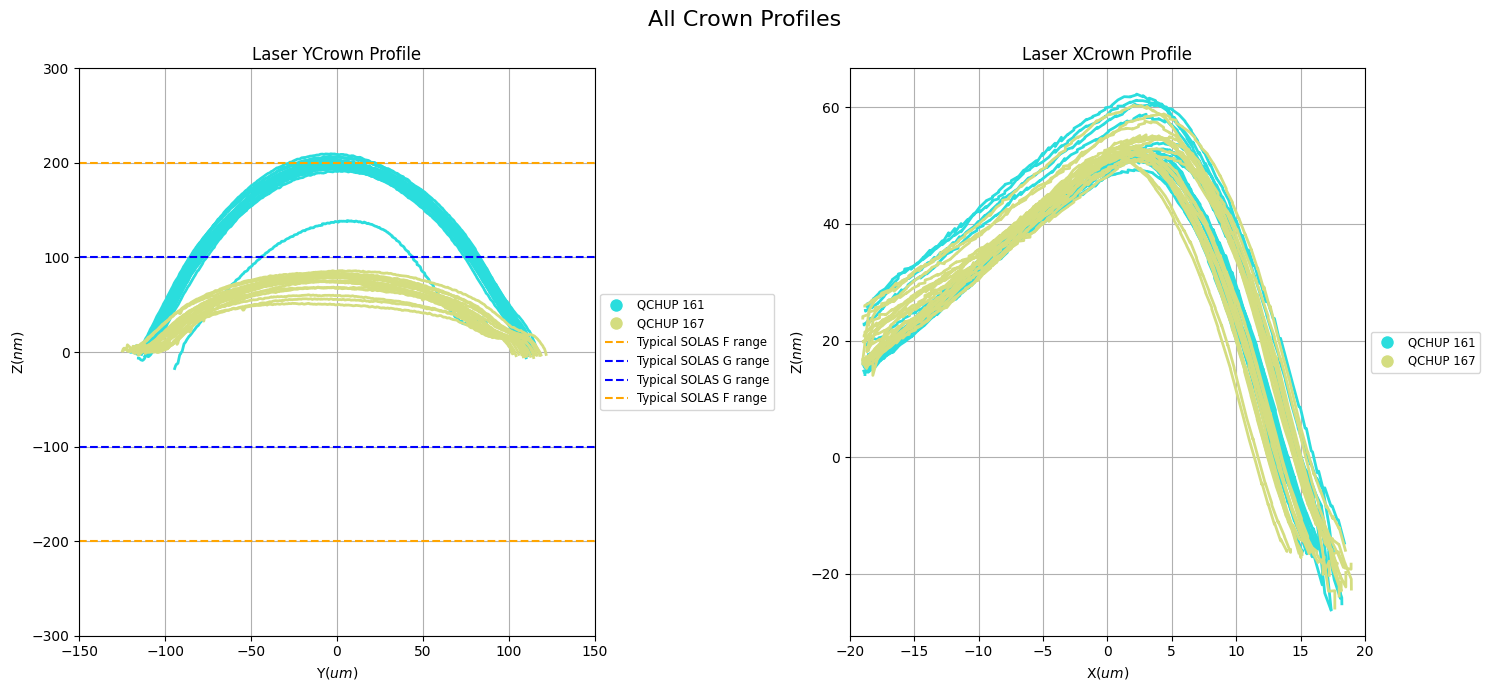

In [13]:
# ---------------------------------- Combined Crown Profile Plot --------------------------------- #
# Function to plot all crown profiles with horizontal lines and annotations in the legend for Y-Crown plots only
def plot_all_crown_profiles(
    data_crownprofiles,
    data_xcrownprofiles,
    datasets,
    designinfos,
    group_by_design_info,
    output_path,
    campaign_name,
    summary_lims,
    palette_name="rainbow",
    y_positions=None,
    border_colours=None,
    annotations=None,
):
    # Extract waferIDs and cubeIDs from datasets
    waferIDs = [dataset.split("_CUBE_")[0] for dataset in datasets]
    cubeIDs = [dataset.split("_CUBE_")[1] for dataset in datasets]

    # Define unique design infos and corresponding colors
    unique_design_infos = list(set(designinfos))
    legendnames = (
        unique_design_infos
        if group_by_design_info
        else [f"{waferID} {cubeID}" for waferID, cubeID in zip(waferIDs, cubeIDs)]
    )

    # Generate unique colors for each profile
    num_profiles = len(data_crownprofiles)
    if group_by_design_info:
        colors = generate_unique_colors(len(designinfos), palette_name)
    else:
        colors = generate_unique_colors(num_profiles, palette_name)

    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    fig.suptitle("All Crown Profiles", fontsize=16)

    # Plot Y-Crown Profiles
    ax1 = axes[0]
    for dataind in range(len(data_crownprofiles)):
        for laserIDind in range(len(data_crownprofiles[dataind])):
            crown_profile = data_crownprofiles[dataind][laserIDind]
            color = (
                colors[unique_design_infos.index(designinfos[dataind])]
                if group_by_design_info
                else colors[dataind]
            )
            ax1.plot(crown_profile[:, 0], crown_profile[:, 1], color=color, linewidth=2)

    ax1.set_xlabel("Y$(um)$")
    ax1.set_ylabel("Z$(nm)$")
    ax1.set_title("Laser YCrown Profile")
    ax1.grid(True)
    ax1.set_xlim([-150, 150])
    ax1.set_ylim(summary_lims)

    # Plot X-Crown Profiles
    ax2 = axes[1]
    for dataind in range(len(data_xcrownprofiles)):
        for laserIDind in range(len(data_xcrownprofiles[dataind])):
            xcrown_profile = data_xcrownprofiles[dataind][laserIDind]
            color = (
                colors[unique_design_infos.index(designinfos[dataind])]
                if group_by_design_info
                else colors[dataind]
            )
            ax2.plot(xcrown_profile[:, 0], xcrown_profile[:, 1], color=color, linewidth=2)

    ax2.set_xlabel("X$(um)$")
    ax2.set_ylabel("Z$(nm)$")
    ax2.set_title("Laser XCrown Profile")
    ax2.grid(True)
    ax2.set_xlim([-20, 20])

    # Add dashed horizontal lines without annotations on the plot
    if y_positions and border_colours:
        for i in range(len(y_positions)):
            ax1.axhline(y=y_positions[i], linestyle="--", color=border_colours[i], linewidth=1.5)

    # Add legends with annotations for Y-Crown plot only
    handles_ycrown = [
        plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color, markersize=10)
        for color in colors[: len(legendnames)]
    ]

    # Add horizontal line annotations to the legend handles for Y-Crown plot only
    if y_positions and border_colours and annotations:
        for i in range(len(y_positions)):
            handles_ycrown.append(
                plt.Line2D([0], [0], linestyle="--", color=border_colours[i], linewidth=1.5)
            )

        legendnames_with_annotations = legendnames + annotations

    # Dynamically set the number of columns in the legend for Y-Crown plot only
    num_columns_ycrown = min(
        4, (len(legendnames_with_annotations) + 19) // 20
    )  # Adjust the divisor to control the number of columns

    ax1.legend(
        handles_ycrown,
        legendnames_with_annotations,
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        ncol=num_columns_ycrown,
        fontsize="small",
    )

    # Add legends without annotations for X-Crown plot
    handles_xcrown = [
        plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color, markersize=10)
        for color in colors[: len(legendnames)]
    ]

    # Dynamically set the number of columns in the legend for X-Crown plot only
    num_columns_xcrown = min(
        4, (len(legendnames) + 19) // 20
    )  # Adjust the divisor to control the number of columns

    ax2.legend(
        handles_xcrown,
        legendnames,
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        ncol=num_columns_xcrown,
        fontsize="small",
    )

    plt.tight_layout()
    output_file = os.path.join(output_path, f"{campaign_name}_All_Crown_Profiles.png")
    plt.savefig(output_file, bbox_inches="tight")


# Example usage with horizontal lines and annotations in the legend
y_positions = [-200, -100, 100, 200]
border_colours = ["#FFA500", "blue", "blue", "#FFA500"]
annotations = [
    "Typical SOLAS F range",
    "Typical SOLAS G range",
    "Typical SOLAS G range",
    "Typical SOLAS F range",
]

plot_all_crown_profiles(
    data_crownprofiles,
    data_xcrownprofiles,
    datasets=DATASETS,
    designinfos=DESIGN_INFOS,
    group_by_design_info=False,
    output_path=OUTPUTPATH,
    campaign_name=CAMPAIGN_NAME,
    summary_lims=SUMMARYLIMS,
    palette_name="rainbow",
    y_positions=y_positions,
    border_colours=border_colours,
    annotations=annotations,
)

### Individal Profile Plots per Dataset

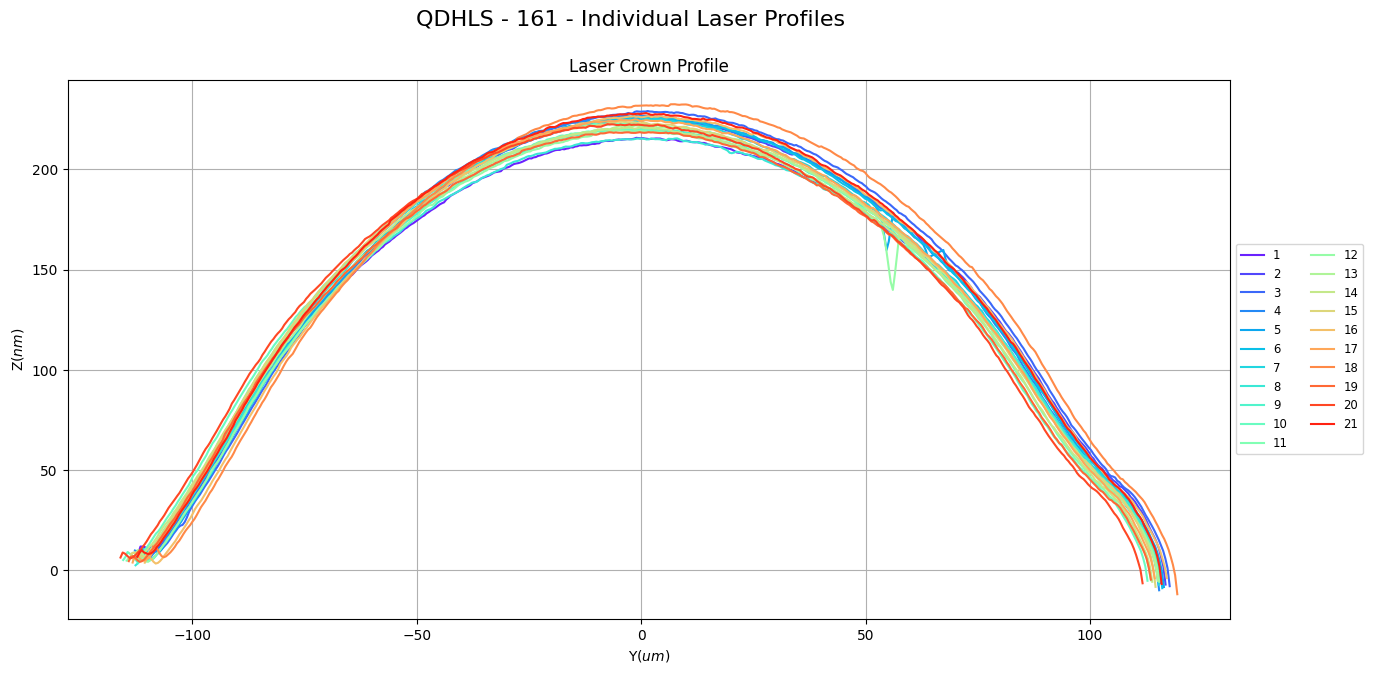

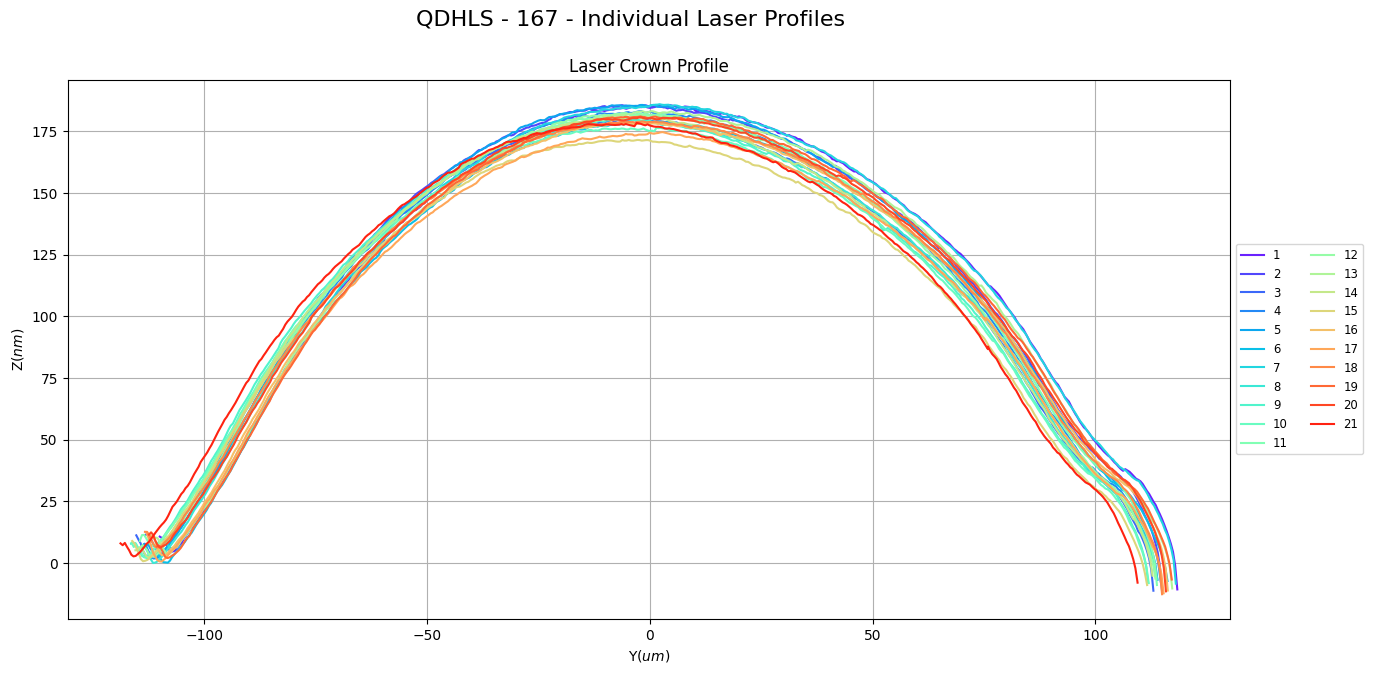

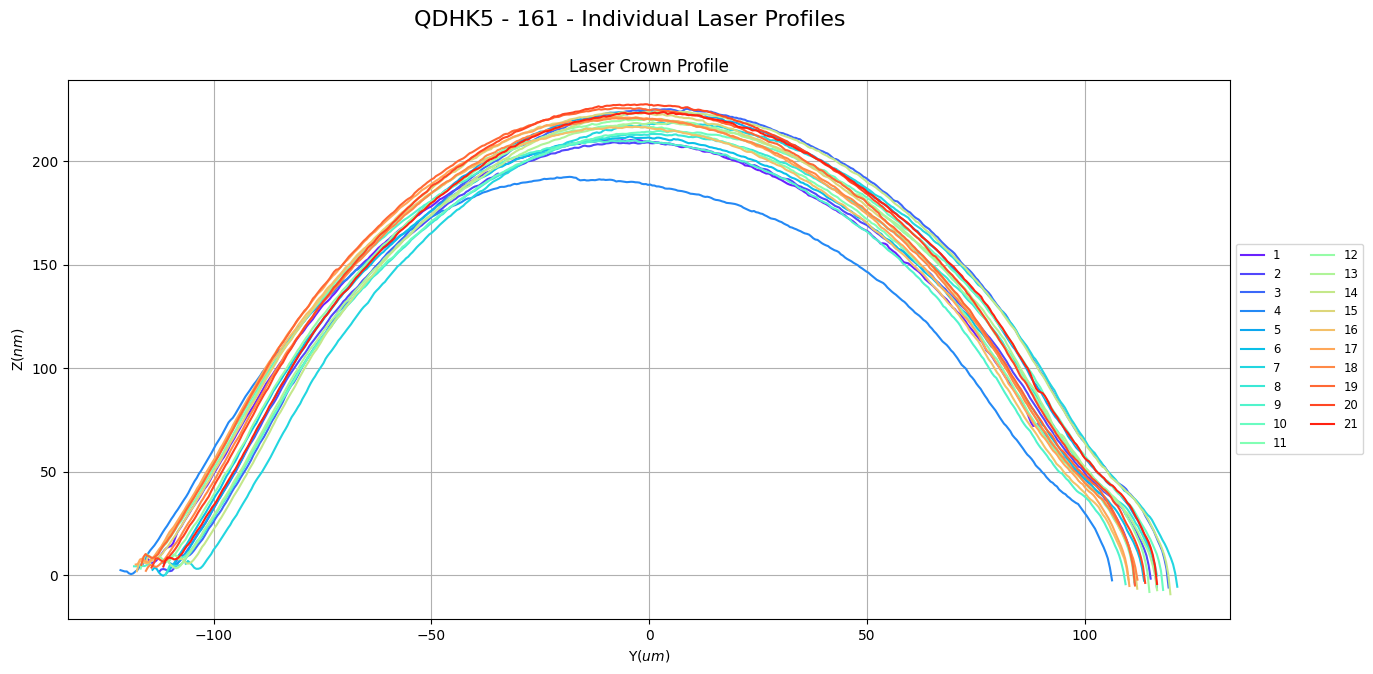

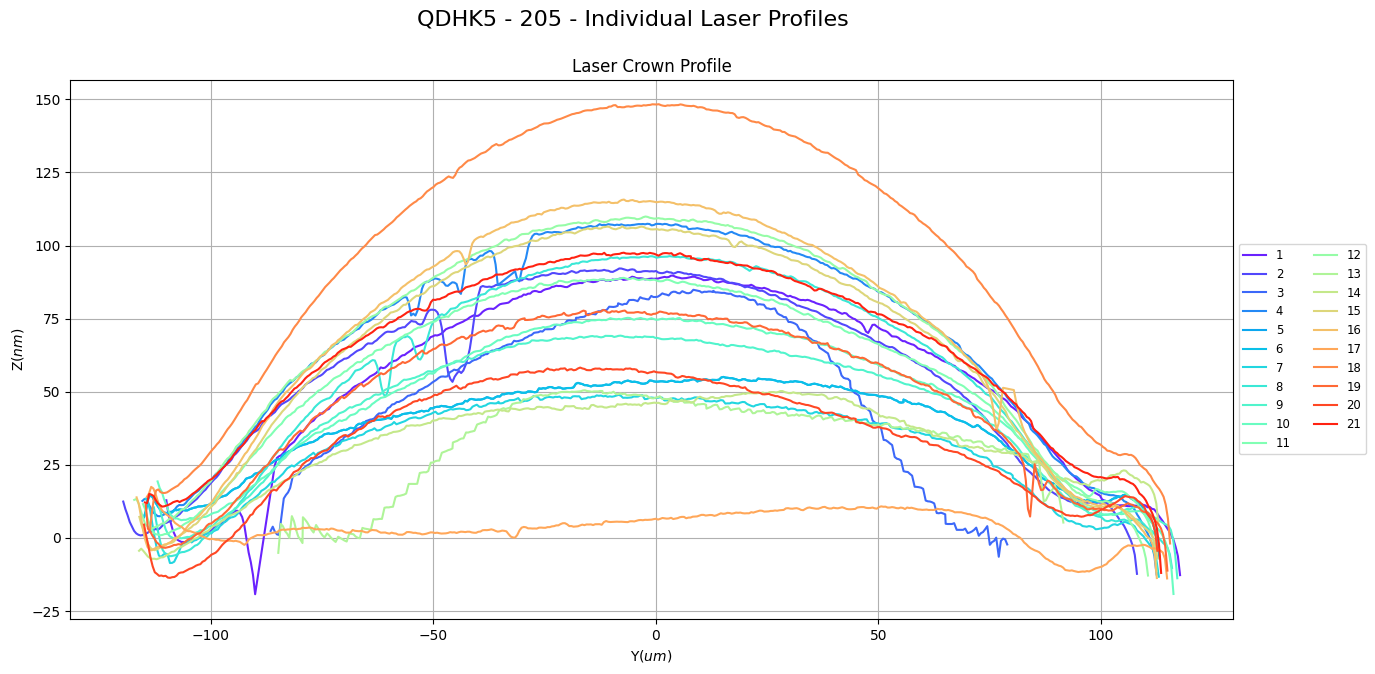

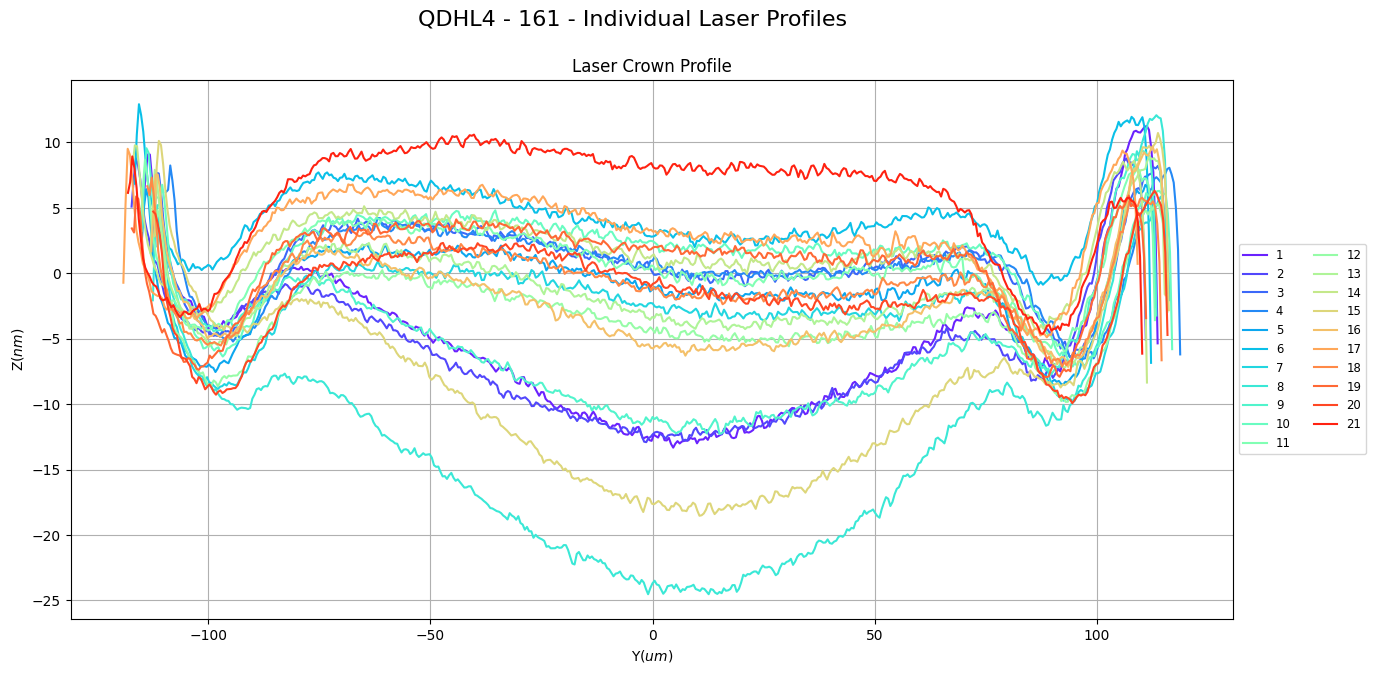

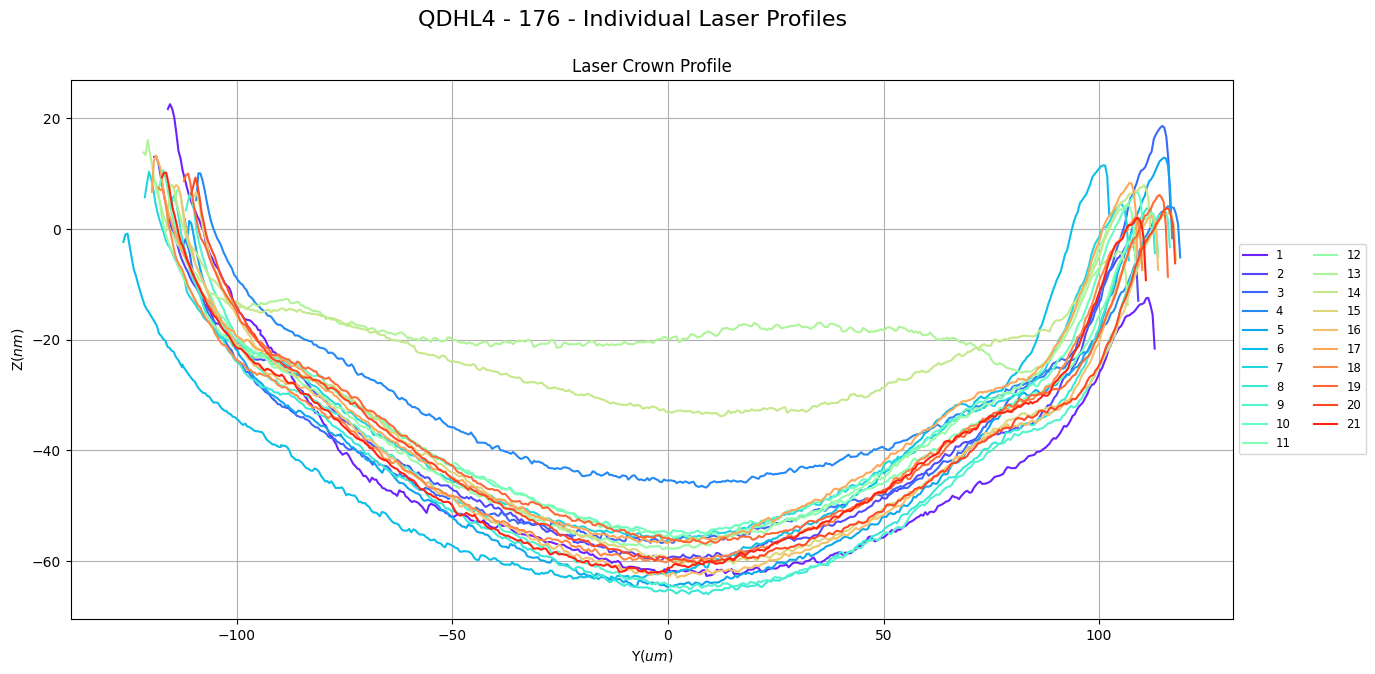

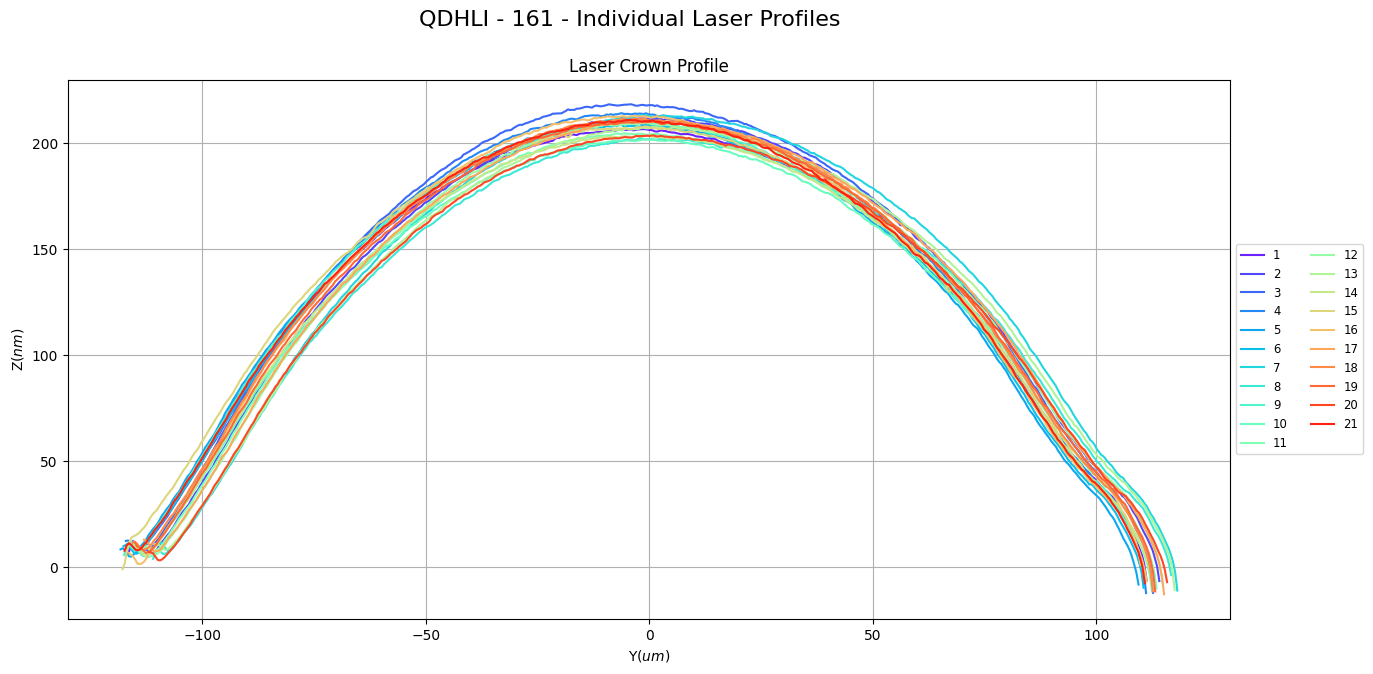

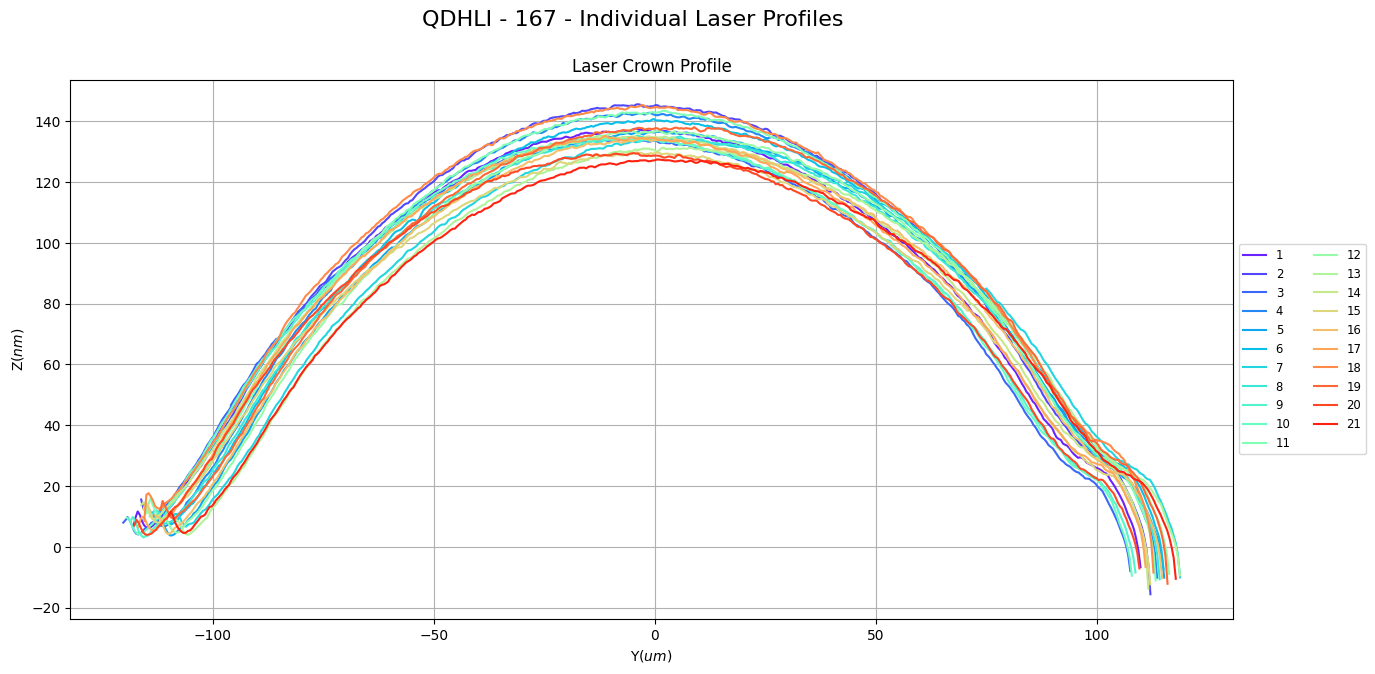

In [42]:
# ------------------------------ Individal Profile Plots per Dataset ----------------------------- #


# Function to plot individual laser profiles for a single dataset
def plot_individual_laser_profiles_single(
    data_crownprofiles, waferID, cubeID, output_path, campaign_name, colour_setting="rainbow"
):
    # Create a new figure for the dataset
    fig, ax = plt.subplots(figsize=(15, 7))
    fig.suptitle(f"{waferID} - {cubeID} - Individual Laser Profiles", fontsize=16)

    # Generate unique colors for each laser profile
    num_profiles = len(data_crownprofiles)
    colors = generate_unique_colors(num_profiles, colour_setting)

    # Plot crown profiles for each laser in the dataset
    for laserIDind in range(num_profiles):
        crown_profile = data_crownprofiles[laserIDind]
        ax.plot(
            crown_profile[:, 0],
            crown_profile[:, 1],
            label=f"{laserIDind + 1}",
            color=colors[laserIDind],
        )

    # Add labels, title, and legend
    ax.set_xlabel("Y$(um)$")
    ax.set_ylabel("Z$(nm)$")
    ax.set_title("Laser Crown Profile")
    ax.grid(True)

    # Dynamically set the number of columns in the legend
    num_columns = min(
        4, (num_profiles + 19) // 20
    )  # Adjust the divisor to control the number of columns
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=num_columns, fontsize="small")

    # Save the figure
    output_file = os.path.join(
        output_path, f"{campaign_name}_{waferID}_{cubeID}_Individual_Laser_Profiles.png"
    )
    plt.savefig(output_file, bbox_inches="tight")


# Example usage: Iterate over each dataset and plot individual laser profiles
for dataind in range(len(DATASETS)):
    waferID, cubeID = DATASETS[dataind].split("_CUBE_")

    plot_individual_laser_profiles_single(
        data_crownprofiles=data_crownprofiles[dataind],
        waferID=waferID,
        cubeID=cubeID,
        output_path=OUTPUTPATH,
        campaign_name=CAMPAIGN_NAME,
    )

### Crown Height Box Plots

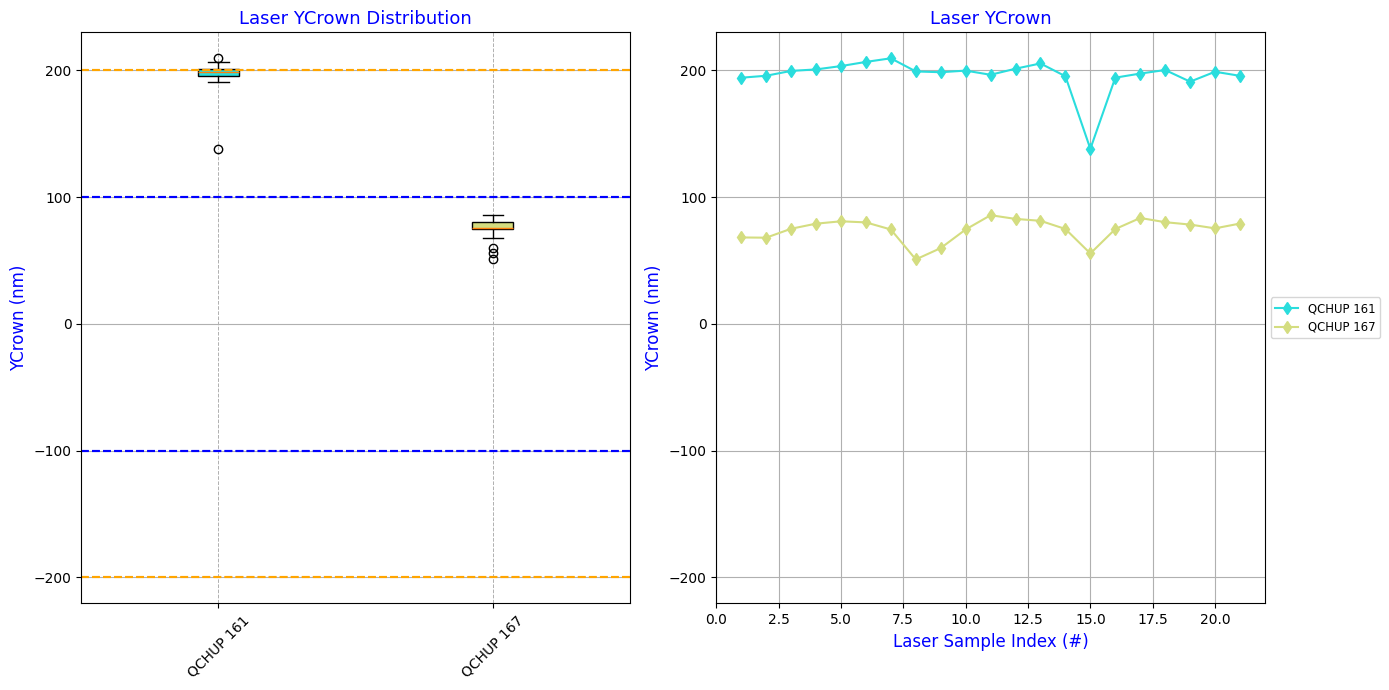

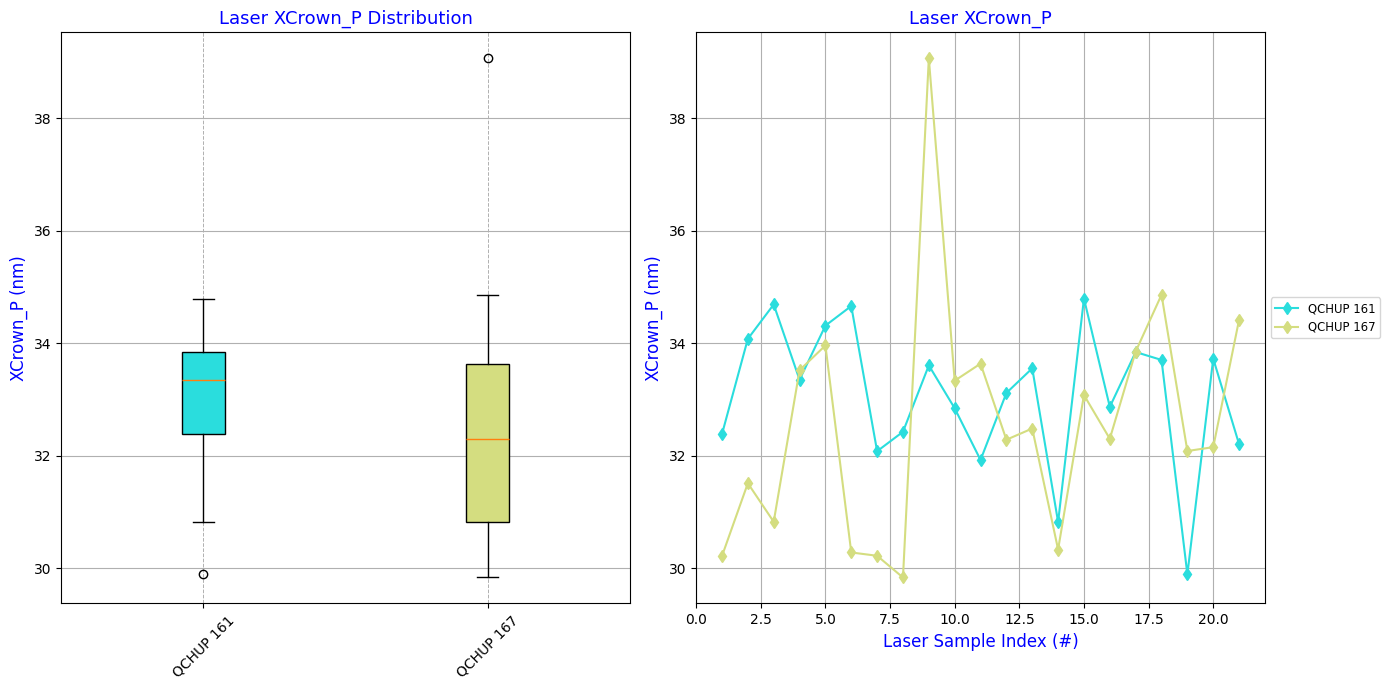

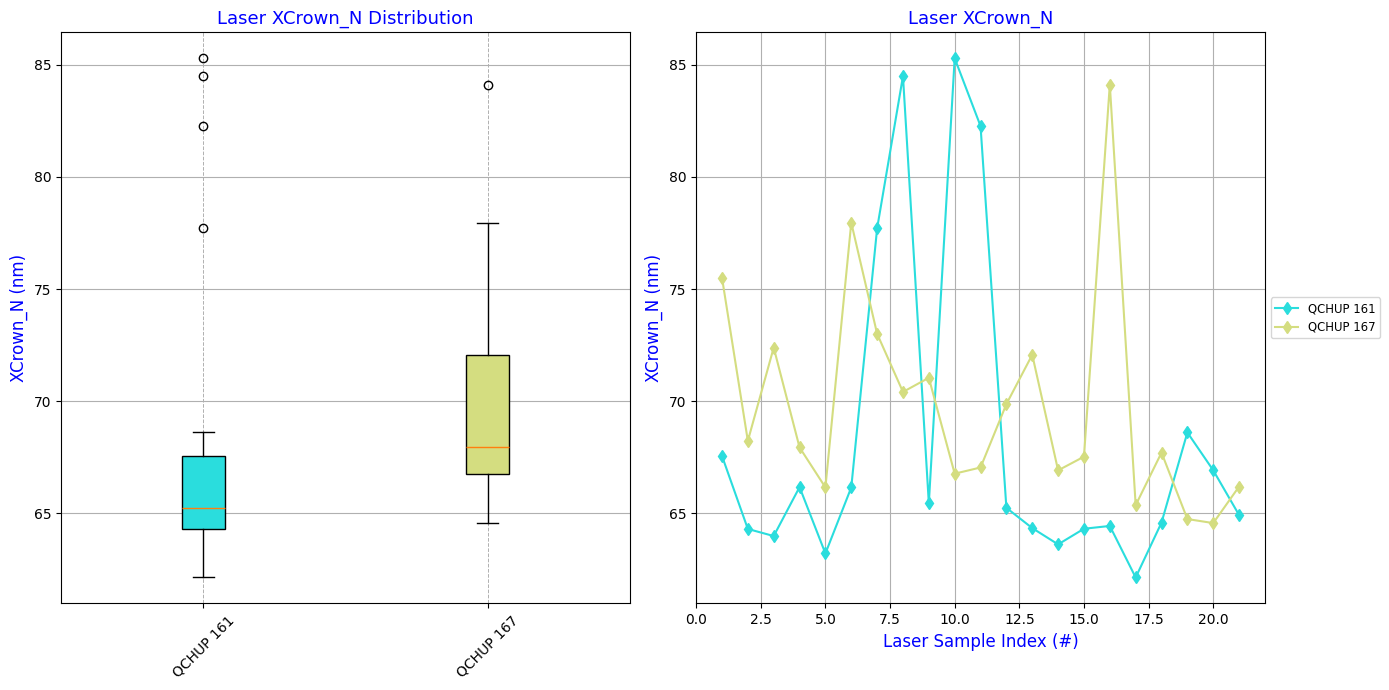

In [14]:
# ------------------------------------- Crown Height Box Plot ------------------------------------ #


# Function to create paired box plots and crown height per laser index plots for a single set of crown data
def create_paired_plot(
    crown_data,
    datasets,
    designinfos,
    group_by_design_info,
    output_path,
    campaign_name,
    ylabel,
    title,
    filename_suffix,
    colour_set="rainbow",
    y_positions=False,
    border_colours=False,
):
    # Define labels and colors
    waferIDs = [dataset.split("_CUBE_")[0] for dataset in datasets]
    cubeIDs = [dataset.split("_CUBE_")[1] for dataset in datasets]
    unique_design_infos = list(set(designinfos))
    legendnames = (
        unique_design_infos
        if group_by_design_info
        else [f"{waferID} {cubeID}" for waferID, cubeID in zip(waferIDs, cubeIDs)]
    )
    num_datasets = len(datasets)

    if group_by_design_info:
        colors_to_use = generate_unique_colors(len(unique_design_infos), colour_set)
        design_info_indices = {
            design_info: idx for idx, design_info in enumerate(unique_design_infos)
        }
    else:
        colors_to_use = generate_unique_colors(num_datasets, colour_set)

    # Box Plot and Crown Height per Laser Index Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    # Box Plot
    yData = []
    group = []
    colorIndex = []

    if group_by_design_info:
        for design_ind in range(len(unique_design_infos)):
            design_info = unique_design_infos[design_ind]
            for dataind in range(len(datasets)):
                if designinfos[dataind] == design_info:
                    yData.extend(crown_data[dataind])
                    group.extend(
                        [design_ind + 1] * len(crown_data[dataind])
                    )  # Adjusted to start from 1
                    colorIndex.extend([design_ind] * len(crown_data[dataind]))
        box_data = [yData[i :: len(unique_design_infos)] for i in range(len(unique_design_infos))]
        box = axes[0].boxplot(box_data, patch_artist=True)
        for patch, color in zip(box["boxes"], colors_to_use):
            patch.set_facecolor(color)
    else:
        for dataind, dataset in enumerate(datasets):
            yData.append(crown_data[dataind])
        box = axes[0].boxplot(yData, patch_artist=True)
        for patch, color in zip(box["boxes"], colors_to_use):
            patch.set_facecolor(color)

    axes[0].set_xticks(range(1, len(legendnames) + 1))
    axes[0].set_xticklabels(legendnames, rotation=45)
    axes[0].set_ylabel(ylabel, fontsize=12, color="b")
    axes[0].set_title(f"Laser {title} Distribution", fontsize=13, color="b")
    axes[0].yaxis.grid(True)
    axes[0].xaxis.grid(True, which="both", linestyle="--", linewidth=0.7)

    if y_positions and border_colours:
        for i in range(len(y_positions)):
            axes[0].axhline(
                y=y_positions[i], linestyle="--", color=border_colours[i], linewidth=1.5
            )

    # Crown Height per Laser Index Plot
    if group_by_design_info:
        plotted_design_infos = set()
        for dataind in range(len(datasets)):
            design_info = designinfos[dataind]
            color_idx = design_info_indices[design_info]
            xData = np.arange(1, len(crown_data[dataind]) + 1)
            yData = crown_data[dataind]
            if design_info not in plotted_design_infos:
                axes[1].plot(
                    xData, yData, "d-", color=colors_to_use[color_idx], label=legendnames[color_idx]
                )
                plotted_design_infos.add(design_info)
            else:
                axes[1].plot(xData, yData, "d-", color=colors_to_use[color_idx])

        handles, labels = axes[1].get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        axes[1].legend(by_label.values(), by_label.keys())

    else:
        for dataind in range(len(datasets)):
            xData = np.arange(1, len(crown_data[dataind]) + 1)
            yData = crown_data[dataind]
            axes[1].plot(
                xData, yData, "d-", color=colors_to_use[dataind], label=legendnames[dataind]
            )
        axes[1].legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="small")

    axes[1].set_xlabel("Laser Sample Index (#)", fontsize=12, color="b")
    axes[1].set_ylabel(ylabel, fontsize=12, color="b")
    axes[1].set_title(f"Laser {title}", fontsize=13, color="b")
    axes[1].grid(True)

    # Set the same y-limits for both plots
    ylim = axes[0].get_ylim()
    axes[1].set_ylim(ylim)

    if y_positions and border_colours:
        for i in range(len(y_positions)):
            axes[0].axhline(
                y=y_positions[i], linestyle="--", color=border_colours[i], linewidth=1.5
            )

    plt.tight_layout()

    # Save the figure
    output_file = f"{output_path}/{campaign_name}_{filename_suffix}_Paired_Plot.png"
    plt.savefig(output_file, dpi=300)


y_positions = [-200, -100, 100, 200]
border_colours = ["#FFA500", "blue", "blue", "#FFA500"]

create_paired_plot(
    [data[:, 0] for data in data_crowns],
    DATASETS,
    DESIGN_INFOS,
    False,
    OUTPUTPATH,
    CAMPAIGN_NAME,
    "YCrown (nm)",
    "YCrown",
    "YCrown",
    "rainbow",
    y_positions,
    border_colours,
)
create_paired_plot(
    [data[:, 1] for data in data_crowns],
    DATASETS,
    DESIGN_INFOS,
    False,
    OUTPUTPATH,
    CAMPAIGN_NAME,
    "XCrown_P (nm)",
    "XCrown_P",
    "XCrownP",
)
create_paired_plot(
    [data[:, 2] for data in data_crowns],
    DATASETS,
    DESIGN_INFOS,
    False,
    OUTPUTPATH,
    CAMPAIGN_NAME,
    "XCrown_N (nm)",
    "XCrown_N",
    "XCrownN",
)